# Description

An airline is tasked with efficiently allocating its available workforce to complete a set of airport operations. Each staff member possesses varying skill levels and can execute specific subsets of these operations, as defined by time and skill constraints. Start and end times are provided for each operation, allowing assessment of consecutive task assignments. Additionally, operations are classified by required skill levels, permitting only staff members with the specified or higher skill level to perform them. Compliance with union regulations imposes maximum working time limits on staff members.

## Objectives

1. Primary: Minimise the utilisation of staff members used to complete these tasks.
2. Secondary: Minimise the total difference between the skill of the staff member and the skill required to complete the task.

## Constraints

1. Assignment Constraint: Ensure that each task is assigned to one and only one staff member.
2. Skill Constraints: Enforce that staff members are only assigned to tasks that match their skill level or below.
3. Maximum Working Time: Abide by union-defined regulations by ensuring that the cumulative working time of each staff member remains within the maximum limit.


### Data Overview

In [12]:
import pandas as pd

staff_df = pd.read_csv("/Users/lm/Desktop/Projects/Schedule/Staff.csv")
tasks_df = pd.read_csv("/Users/lm/Desktop/Projects/Schedule/Tasks.csv")

In [13]:
staff_df.head()

,Staff_ID,Staff_Name,Max_Hours,Skill_Level
0,1,Ann,6,2
1,2,Bob,4,1
2,3,Carla,4,2
3,4,Darren,4,1
4,5,Eliza,7,1


In [14]:
tasks_df.head()

,Task_ID,Start_Time,End_Time,Skill_Required
0,1,6,9,1
1,2,2,3,1
2,3,10,12,2
3,4,7,8,1
4,5,6,9,1


In [15]:
# Number of tasks and staff members
num_tasks = len(tasks_df)
num_staff = len(staff_df)

# Average maximum working hours for staff
avg_max_hours_staff = staff_df["Max_Hours"].mean()

# Average task duration
tasks_df["Duration"] = tasks_df["End_Time"] - tasks_df["Start_Time"]
avg_task_duration = tasks_df["Duration"].mean()

# Distribution of skill levels among tasks and staff members
skill_distribution_staff = staff_df["Skill_Level"].value_counts(normalize=True)
skill_distribution_tasks = tasks_df["Skill_Required"].value_counts(normalize=True)


print("Summary")

print(f"1. There are a total of {num_tasks} tasks to complete.")
print(f"2. There are a total of {num_staff} staff members.")
print(f"3. The average duration of a task is {avg_task_duration:.2f} hours.")
print(f"4. On average, a staff member can work a maximum {avg_max_hours_staff:.2f} hours a day.")
print(f"5. The skill level required for the tasks are distributed as follows:  Skill 1 - {skill_distribution_tasks[1]*100:.2f}%, Skill 2 - {skill_distribution_tasks[2]*100:.2f}%, Skill 3 - {skill_distribution_tasks[3]*100:.2f}%.")
print(f"6. Among the staff, the skill levels possessed are distributed as follows: Skill 1 - {skill_distribution_staff[1]*100:.2f}%, Skill 2 - {skill_distribution_staff[2]*100:.2f}%, Skill 3 - {skill_distribution_staff[3]*100:.2f}%.")


Summary
1. There are a total of 20 tasks to complete.
2. There are a total of 26 staff members.
3. The average duration of a task is 1.80 hours.
4. On average, a staff member can work a maximum 5.19 hours a day.
5. The skill level required for the tasks are distributed as follows:  Skill 1 - 40.00%, Skill 2 - 35.00%, Skill 3 - 25.00%.
6. Among the staff, the skill levels possessed are distributed as follows: Skill 1 - 30.77%, Skill 2 - 34.62%, Skill 3 - 34.62%.


### Model Optimisation

In [16]:
import gurobipy as gp
from gurobipy import GRB

model = gp.Model("AirlineStaffScheduling")

# Decision Variables
x = model.addVars(len(staff_df), len(tasks_df), vtype=GRB.BINARY, name="x")
y = model.addVars(len(staff_df), vtype=GRB.BINARY, name="y")

# Primary Objective
primary_obj = y.sum()

# Secondary Objective
skill_difference = gp.quicksum(x[i,j] * (staff_df.loc[i, "Skill_Level"] - tasks_df.loc[j, "Skill_Required"])
                               for i in range(len(staff_df))
                               for j in range(len(tasks_df)))

# Total Objective
model.setObjective(primary_obj + skill_difference, GRB.MINIMIZE)

# Constraints

# Each task should be assigned to at most one staff member
for j in range(len(tasks_df)):
    model.addConstr(x.sum('*', j) == 1)

# Staff members should only be assigned tasks for which they have the required skill level or higher
for i in range(len(staff_df)):
    for j in range(len(tasks_df)):
        if staff_df.loc[i, "Skill_Level"] < tasks_df.loc[j, "Skill_Required"]:
            model.addConstr(x[i, j] == 0)

# The total working time for each staff member should not exceed their maximum allowed working hours
for i in range(len(staff_df)):
    model.addConstr(gp.quicksum(x[i, j] * (tasks_df.loc[j, "End_Time"] - tasks_df.loc[j, "Start_Time"])
                                for j in range(len(tasks_df))) <= staff_df.loc[i, "Max_Hours"])

# If a staff member is assigned any task, then y[i] = 1
M = len(tasks_df)  # Maximum number of tasks
for i in range(len(staff_df)):
    model.addConstr(x.sum(i, '*') <= M * y[i])

model.optimize()


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 213 rows, 546 columns and 1727 nonzeros
Model fingerprint: 0x7e81b4e1
Variable types: 0 continuous, 546 integer (546 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 26.0000000
Presolve removed 142 rows and 145 columns
Presolve time: 0.00s
Presolved: 71 rows, 401 columns, 1140 nonzeros
Variable types: 0 continuous, 401 integer (401 binary)
Found heuristic solution: objective 15.0000000

Root relaxation: objective 3.564286e+00, 99 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.56429    0  

     0     0    4.20000    0   19    6.00000    4.20000  30.0%     -    0s
     0     0    4.20000    0   16    6.00000    4.20000  30.0%     -    0s

Cutting planes:
  Gomory: 5
  Cover: 8
  Clique: 13
  MIR: 8
  GUB cover: 1

Explored 1 nodes (541 simplex iterations) in 0.04 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 6 7 15 26 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.000000000000e+00, best bound 6.000000000000e+00, gap 0.0000%


The model has found an optimal solution of 6. I will validate the results below.

### Result Validation

In [17]:
# Count the number of tasks that have been assigned/completed
completed_tasks = sum(1 for i in range(len(staff_df)) for j in range(len(tasks_df)) if x[i, j].X > 0.5)

completed_tasks

20

In [18]:
# Review the allocation of tasks to respective staff members

assignment_data = {'Task_ID': [], 'Staff_Name': [], 'Start_Time': [], 'End_Time': []}

for i in range(len(staff_df)):
    for j in range(len(tasks_df)):
        if x[i, j].X > 0.5:  # if the staff member i is assigned to task j
            assignment_data['Task_ID'].append(tasks_df.loc[j, 'Task_ID'])
            assignment_data['Staff_Name'].append(staff_df.loc[i, 'Staff_Name'])
            assignment_data['Start_Time'].append(tasks_df.loc[j, 'Start_Time'])
            assignment_data['End_Time'].append(tasks_df.loc[j, 'End_Time'])

assignment_df = pd.DataFrame(assignment_data)
print(assignment_df)


    Task_ID Staff_Name  Start_Time  End_Time
0         2      Eliza           2         3
1         7      Eliza           7         9
2        18      Eliza          14        16
3         8       Gina           6         9
4        15       Gina          17        18
5        19       Gina          20        22
6         5      Peter           6         9
7        16      Peter          13        14
8         3      Sarah          10        12
9        12      Sarah          17        19
10       13      Sarah          18        20
11       14      Sarah          21        22
12        1     Victor           6         9
13        4     Victor           7         8
14       20     Victor          18        21
15        6     Yasmin           9        11
16        9     Yasmin          11        12
17       10     Yasmin          19        20
18       11     Yasmin          15        16
19       17     Yasmin          16        18


In [19]:
# Calculate the total hours assigned to each staff member and compare with their max hours

assigned_hours_data = {'Staff_Name': [], 'Assigned_Hours': [], 'Max_Hours': []}

for i in range(len(staff_df)):
    total_hours_assigned = sum(x[i, j].X * (tasks_df.loc[j, "End_Time"] - tasks_df.loc[j, "Start_Time"])
                               for j in range(len(tasks_df)))
    if total_hours_assigned != 0:
        assigned_hours_data['Staff_Name'].append(staff_df.loc[i, 'Staff_Name'])
        assigned_hours_data['Assigned_Hours'].append(total_hours_assigned)
        assigned_hours_data['Max_Hours'].append(staff_df.loc[i, 'Max_Hours'])

assigned_hours_df = pd.DataFrame(assigned_hours_data)
assigned_hours_df['Within_Limit'] = assigned_hours_df['Assigned_Hours'] <= assigned_hours_df['Max_Hours']
assigned_hours_df

,Staff_Name,Assigned_Hours,Max_Hours,Within_Limit
0,Eliza,5.0,7,True
1,Gina,6.0,6,True
2,Peter,4.0,7,True
3,Sarah,7.0,7,True
4,Victor,7.0,7,True
5,Yasmin,7.0,7,True


In [20]:
# Calculate the skill level for tasks assigned to each staff member and compare with the required skill level

skill_data = {'Staff_Name': [], 'Task_ID': [], 'Staff_Skill_Level': [], 'Task_Skill_Required': []}

for i in range(len(staff_df)):
    for j in range(len(tasks_df)):
        if x[i, j].X > 0.5:  # if the staff member i is assigned to task j
            skill_data['Staff_Name'].append(staff_df.loc[i, 'Staff_Name'])
            skill_data['Task_ID'].append(tasks_df.loc[j, 'Task_ID'])
            skill_data['Staff_Skill_Level'].append(staff_df.loc[i, 'Skill_Level'])
            skill_data['Task_Skill_Required'].append(tasks_df.loc[j, 'Skill_Required'])

skill_comparison_df = pd.DataFrame(skill_data)
skill_comparison_df['Skill_Difference'] = skill_comparison_df['Staff_Skill_Level'] - skill_comparison_df['Task_Skill_Required']
skill_comparison_df['No_Skill_Difference'] = skill_comparison_df['Skill_Difference'] == 0

skill_comparison_df


,Staff_Name,Task_ID,Staff_Skill_Level,Task_Skill_Required,Skill_Difference,No_Skill_Difference
0,Eliza,2,1,1,0,True
1,Eliza,7,1,1,0,True
2,Eliza,18,1,1,0,True
3,Gina,8,2,2,0,True
4,Gina,15,2,2,0,True
5,Gina,19,2,2,0,True
6,Peter,5,1,1,0,True
7,Peter,16,1,1,0,True
8,Sarah,3,2,2,0,True
9,Sarah,12,2,2,0,True


Now that we have confirmed the model has satisfied each of our constraints, I will proceed with visualising the results.

### Visualising Results

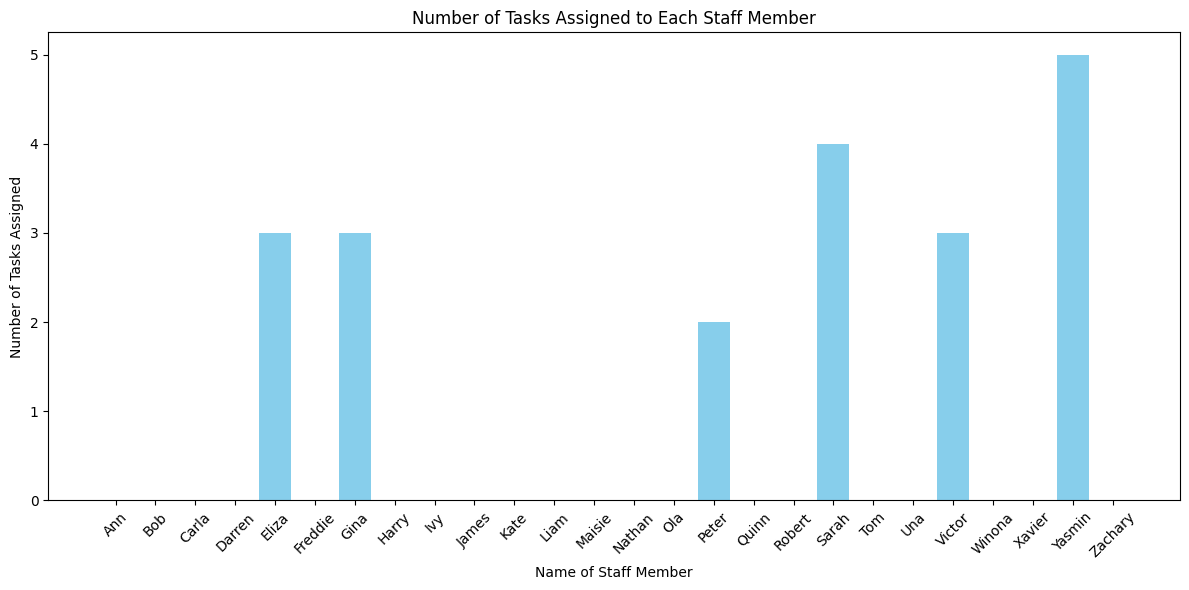

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart of Staff Assignments
staff_assignments = [sum(x[i, j].X for j in range(len(tasks_df))) for i in range(len(staff_df))]
plt.figure(figsize=(12, 6))
plt.bar(staff_df['Staff_Name'], staff_assignments, color='skyblue')
plt.xlabel('Name of Staff Member')
plt.ylabel('Number of Tasks Assigned')
plt.title('Number of Tasks Assigned to Each Staff Member')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



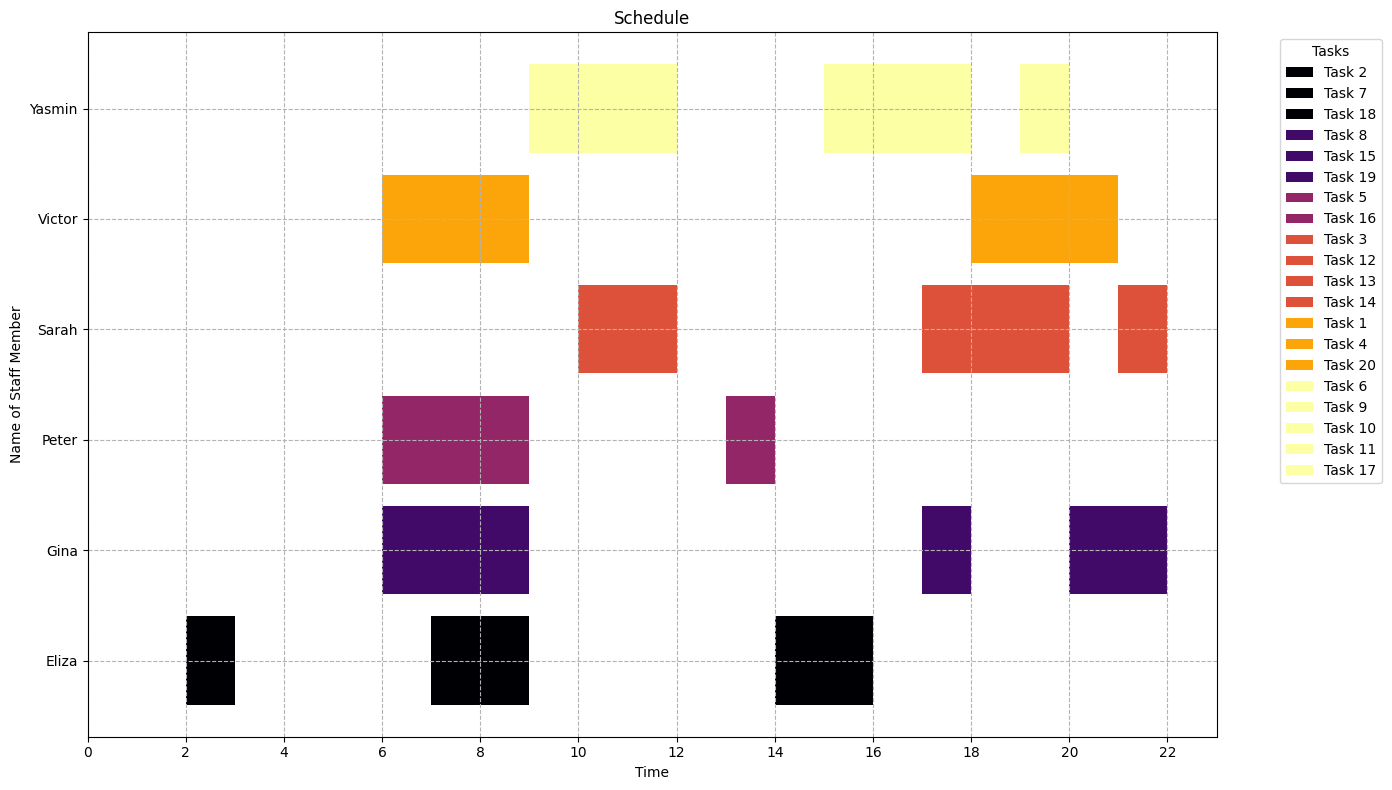

In [22]:
import numpy as np

# Gantt chart for schedule
fig, ax = plt.subplots(figsize=(14, 8))
staff_names = assignment_df["Staff_Name"].unique()

colors = plt.cm.inferno(np.linspace(0, 1, len(staff_names)))

for index, staff_name in enumerate(staff_names):
    staff_data = assignment_df[assignment_df["Staff_Name"] == staff_name]
    for _, row in staff_data.iterrows():
        ax.barh(staff_name, 
                width=row["End_Time"] - row["Start_Time"], 
                left=row["Start_Time"], 
                color=colors[index], 
                label=f"Task {row['Task_ID']}")

ax.set_xticks(np.arange(0, assignment_df["End_Time"].max() + 1, 2))

# Remove duplicate labels from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Tasks", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlabel("Time")
ax.set_ylabel("Name of Staff Member")
ax.set_title("Schedule")
ax.grid(True, which='both', ls='--', c='0.7')
plt.tight_layout()

plt.show()

## Summary

The problem has been successfully solved with an optimal solution. All 20 shifts have been efficiently covered using only 6 staff members. This achievement aligns with the union's maximum working hours constraints and has optimally assigned tasks to staff who closely match the skill requirements.

This strategic staffing approach, minismising the difference in skill level between the staff member and the skill required to complete the task, is one that results in cost-efficiency. This approach aligns with the economic principle that more experienced or highly skilled staff members typically will have higher wages. This model has successfully achieved a skill difference of 0 across all tasks, meaning we have reduced labour costs and optimised revenue generation for the airline.